# dataset stats and figure generation

The purpose of this notebook is to get the total number of tiles in all the datasets.

## initial setup

load the datasets and all that.

In [1]:
from pathlib import Path

import random
from scale_alibi.dataset.loader import (
    MultimodalDataset,
    LoresMultimodalDataset,
    PMTileDataset,
    PMTile4xDataset,
    LoresMultimodalSample,
    MultimodalSample
)


from torchvision.transforms import Compose
from pmtiles.tile import tileid_to_zxy
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 300
import einops

import numpy as np

LORES_DATASET_PATH_SMALL = Path('../rasters/final/visual_tiles_small.pmtile')
RADAR_DATASET_PATH_SMALL = Path('../rasters/final/sar_tiles_small.pmtile')
HIRES_DATASET_PATH_SMALL = Path('../rasters/final/hires_visual_small.pmtile')
LORES_DATASET_PATH       = Path('../rasters/final/visual_tiles.pmtile')
RADAR_DATASET_PATH       = Path('../rasters/final/sar_tiles.pmtile')
HIRES_DATASET_PATH       = Path('../rasters/final/hires_visual.pmtile')
LORES_DATASET_PATH_MICRO = Path('../rasters/micro/visual_tiles_micro.pmtile')
RADAR_DATASET_PATH_MICRO = Path('../rasters/micro/sar_tiles_micro.pmtile')
HIRES_DATASET_PATH_MICRO = Path('../rasters/micro/hires_visual_micro.pmtile')

In [4]:
def load_lores_dataset(radar_path: Path, lores_path: Path):
    radar_dset = PMTileDataset(radar_path)
    lores_dset = PMTileDataset(lores_path)
    
    return LoresMultimodalDataset(
        radar_dset,
        lores_dset
    )

def load_hires_dataset(
    radar_path: Path,
    lores_path: Path,
    hires_path: Path
):
    radar_dset    = PMTileDataset(radar_path)
    lores_dset    = PMTileDataset(lores_path)
    hires_dset    = PMTileDataset(hires_path)
    hires_4x_dset = PMTile4xDataset(hires_dset)
    
    return MultimodalDataset(
        radar_dset,
        lores_dset,
        hires_dset,
        hires_4x_dset
    )

## small sample dataset

This is a small subsample of the full dataset, centered around tile `9/135/204` and consisting of level 15 tiles (level 16 for 4x).

In [5]:
dataset_small_lores = load_lores_dataset(
    RADAR_DATASET_PATH_SMALL,
    LORES_DATASET_PATH_SMALL
)

dataset_small = load_hires_dataset(
    RADAR_DATASET_PATH_SMALL,
    LORES_DATASET_PATH_SMALL,
    HIRES_DATASET_PATH_SMALL
)

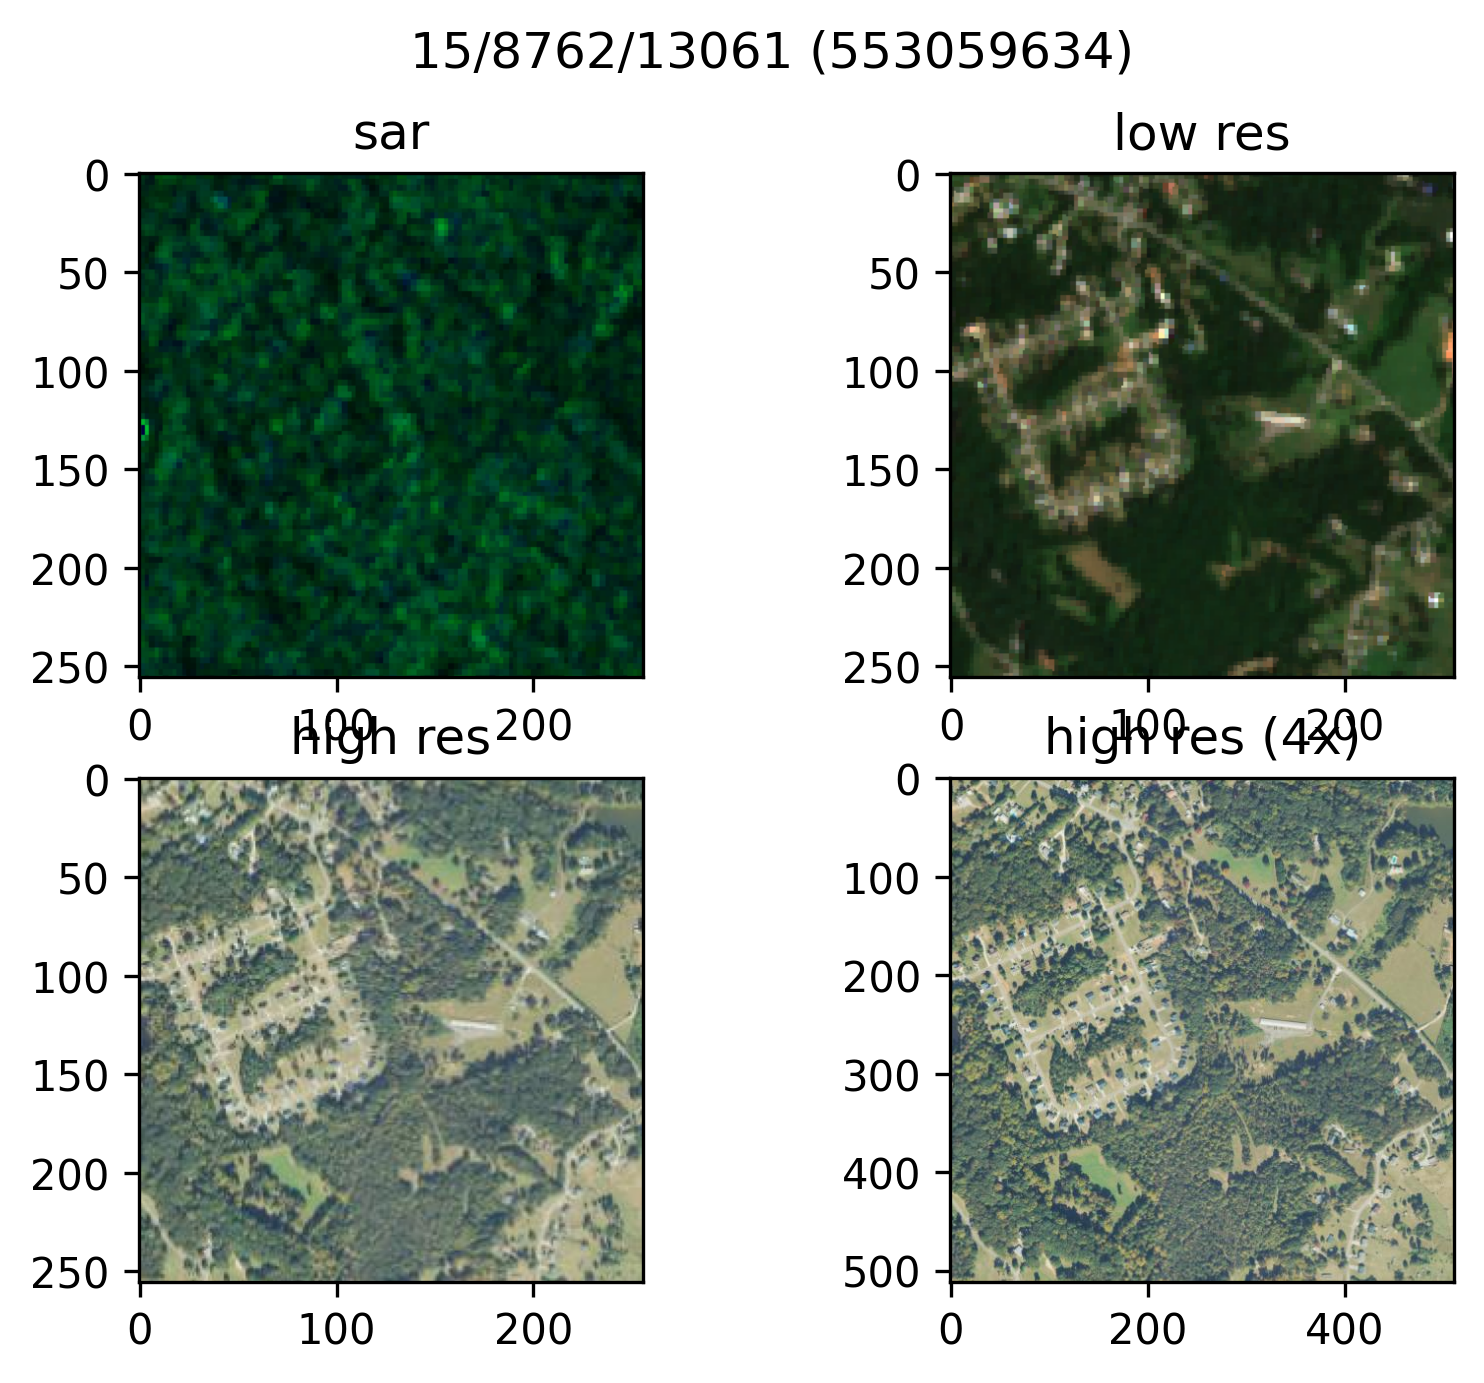

In [8]:
def show_sample(sample):
    if type(sample) is MultimodalSample:
        fig, axs = plt.subplots(2,2)
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(1,2)

    z,x,y = tileid_to_zxy(sample.tile_id)
    
    fig.suptitle(f'{z}/{x}/{y} ({sample.tile_id})')
    
    axs[0].set_title('sar')
    axs[0].imshow(
        sample.radar
    )
    
    axs[1].set_title('low res')
    axs[1].imshow(sample.lores)
    
    
    if type(sample) is MultimodalSample:
        axs[2].set_title('high res')
        axs[2].imshow(sample.hires)
        
        axs[3].set_title('high res (4x)')
        axs[3].imshow(sample.hir4x)
#     axs[2].set_title('hires')
#     axs[2].imshow(sample.hires)
    
    plt.show()

show_sample(random.choice(dataset_small))

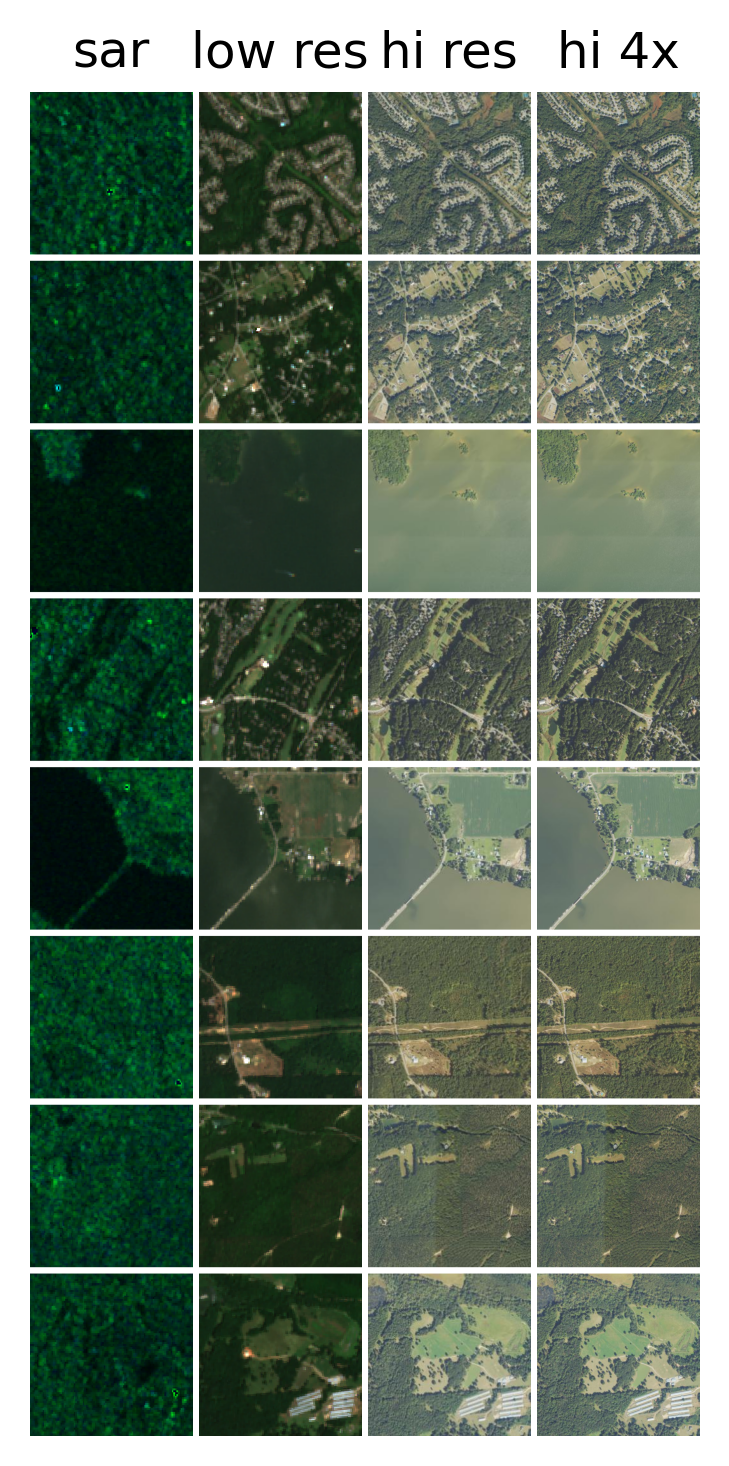

In [84]:
def show_sample_cols(samples):
#     if type(sample) is MultimodalSample:
#         fig, axs = plt.subplots(2,2)
#         axs = axs.flatten()
#     else:
#         fig, axs = plt.subplots(1,2)
    
    
    
    def interp_blanks(imgs, blank_width=10, vertical=False):
        
        
        imgs_out = []
        for s in imgs:
            if (s.shape[-1] == 3):
                s_alpha, _ = einops.pack(
                    [
                        s,
                        np.ones(s.shape[:-1]) * 255
                    ],
                    'h w *'
                )
                imgs_out.append(s_alpha.astype(np.uint8))
            else:
                imgs_out.append(s)
            
            if vertical:
                blank_img = np.ones((s.shape[0], blank_width, 4)) * 255
            else:
                blank_img = np.ones((blank_width,s.shape[0],4)) * 255
            imgs_out.append(blank_img.astype(np.uint8))

        imgs_out = imgs_out[:-1]
        return imgs_out
    
    fig, axs = plt.subplots(1,4)
    
    radar_imgs, _ = einops.pack(
        interp_blanks([s.radar for s in samples]),
        '* w c'
    )
    lores_imgs, _ = einops.pack(
        interp_blanks([s.lores for s in samples]),
        '* w c'
    )
    hires_imgs, _ = einops.pack(
        interp_blanks([s.hires for s in samples]),
        '* w c'
    )
    hir4x_imgs, _ = einops.pack(
        interp_blanks([s.hir4x for s in samples], blank_width=20),
        '* w c'
    )
    
#     z,x,y = tileid_to_zxy(sample.tile_id)
    
#     fig.suptitle(f'{z}/{x}/{y} ({sample.tile_id})')
    
    axs[0].set_title('sar')
    axs[0].imshow(
        radar_imgs
    )
    axs[0].axis('off')
    
    axs[1].set_title('low res')
    axs[1].imshow(
        lores_imgs
    )
    axs[1].axis('off')
    
    axs[2].set_title('hi res')
    axs[2].imshow(
        hires_imgs
    )
    axs[2].axis('off')
    
    axs[3].set_title('hi 4x')
    axs[3].imshow(
        hir4x_imgs
    )
    axs[3].axis('off')
    
    
#     axs[2].set_title('hires')
#     axs[2].imshow(sample.hires)
    # plt.tight_layout()
    plt.tight_layout(pad=0.4, w_pad=-24.5, h_pad=1.0)
    plt.show()


samples_n = [
    random.choice(dataset_small),
    random.choice(dataset_small),
    random.choice(dataset_small),
    random.choice(dataset_small),
    random.choice(dataset_small),
    random.choice(dataset_small),
    random.choice(dataset_small),
    random.choice(dataset_small)
]

show_sample_cols(samples_n)

In [20]:
def stat_datasets(dataset, dataset_lores):
    print('tile counts:')
    print(f'sentinel-1:  {len(dataset.radar_datasets)}')
    print(f'sentinel-2:  {len(dataset.lores_datasets)}')
    print(f'NAIP:        {len(dataset.hires_datasets) // 5}')
    print(f'NAIP_4x:     {4*(len(dataset.hires_datasets) // 5)}')
    print(f'lores joint: {len(dataset_lores)}')
    print(f'full  joint: {len(dataset)}')
    
stat_datasets(dataset_small, dataset_small_lores)

tile counts:
sentinel-1:  83407
sentinel-2:  21917
NAIP:        21917
NAIP_4x:     87668
lores joint: 21497
full  joint: 21497


## micro dataset

not a micro size, but a micro scale: this dataset was built around `12/1087/1637`. Tiles here were generated at level 17, with 4x level 18 tiles being the limit of NAIP resolution.

In [21]:
dataset_micro_lores = load_lores_dataset(
    RADAR_DATASET_PATH_MICRO,
    LORES_DATASET_PATH_MICRO
)

dataset_micro = load_hires_dataset(
    RADAR_DATASET_PATH_MICRO,
    LORES_DATASET_PATH_MICRO,
    HIRES_DATASET_PATH_MICRO
)

In [22]:
stat_datasets(dataset_micro, dataset_micro_lores)

tile counts:
sentinel-1:  939398
sentinel-2:  188060
NAIP:        188060
NAIP_4x:     752240
lores joint: 188060
full  joint: 188060


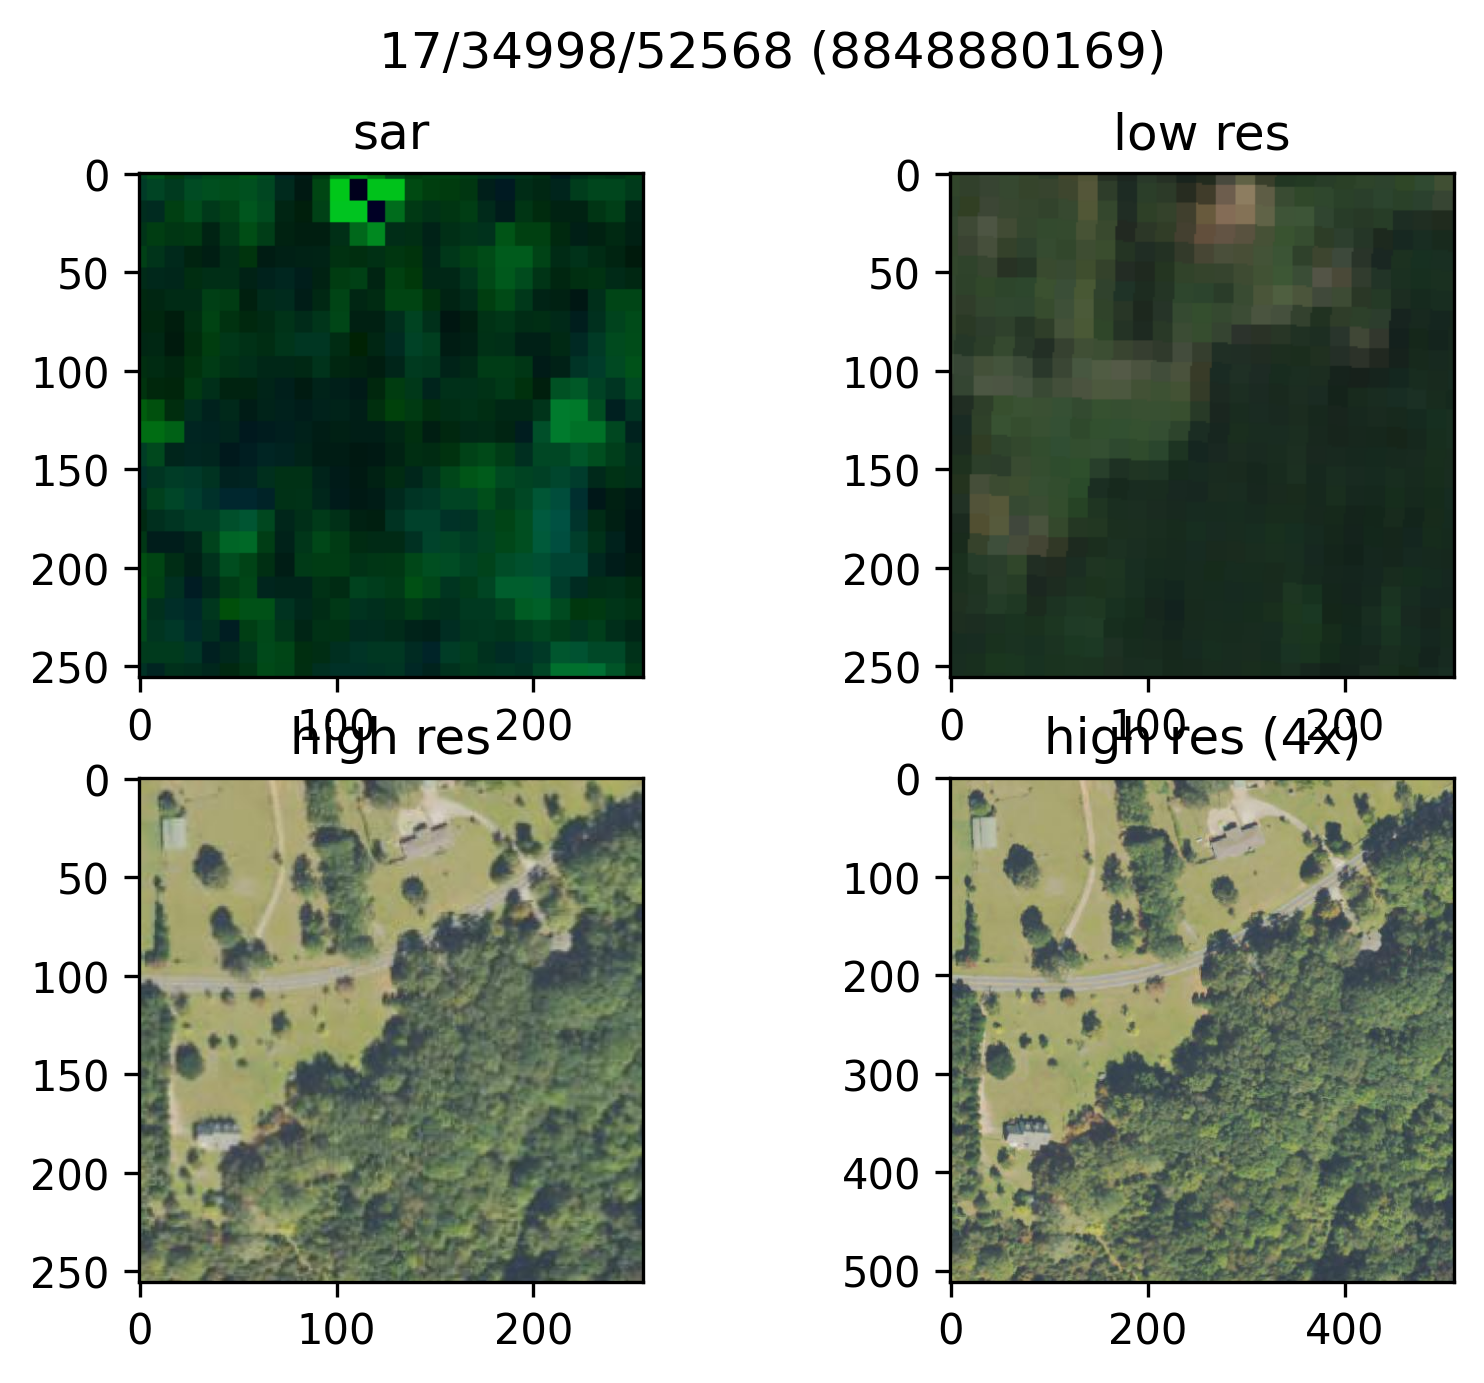

In [29]:
show_sample(random.choice(dataset_micro))

## regular dataset

this is a sample dataset of several locations around CONUS. Source tiles:

- 8/67/102
- 8/44/102
- 8/76/95
- 8/52/96

As before, this consists of level 15 tiles (level 16 for 4x).

In [31]:
dataset_lores = load_lores_dataset(
    RADAR_DATASET_PATH,
    LORES_DATASET_PATH
)

dataset = load_hires_dataset(
    RADAR_DATASET_PATH,
    LORES_DATASET_PATH,
    HIRES_DATASET_PATH
)

In [38]:
stat_datasets(dataset, dataset_lores)

tile counts:
sentinel-1:  304882
sentinel-2:  186250
NAIP:        196759
NAIP_4x:     787036
lores joint: 146502
full  joint: 146502


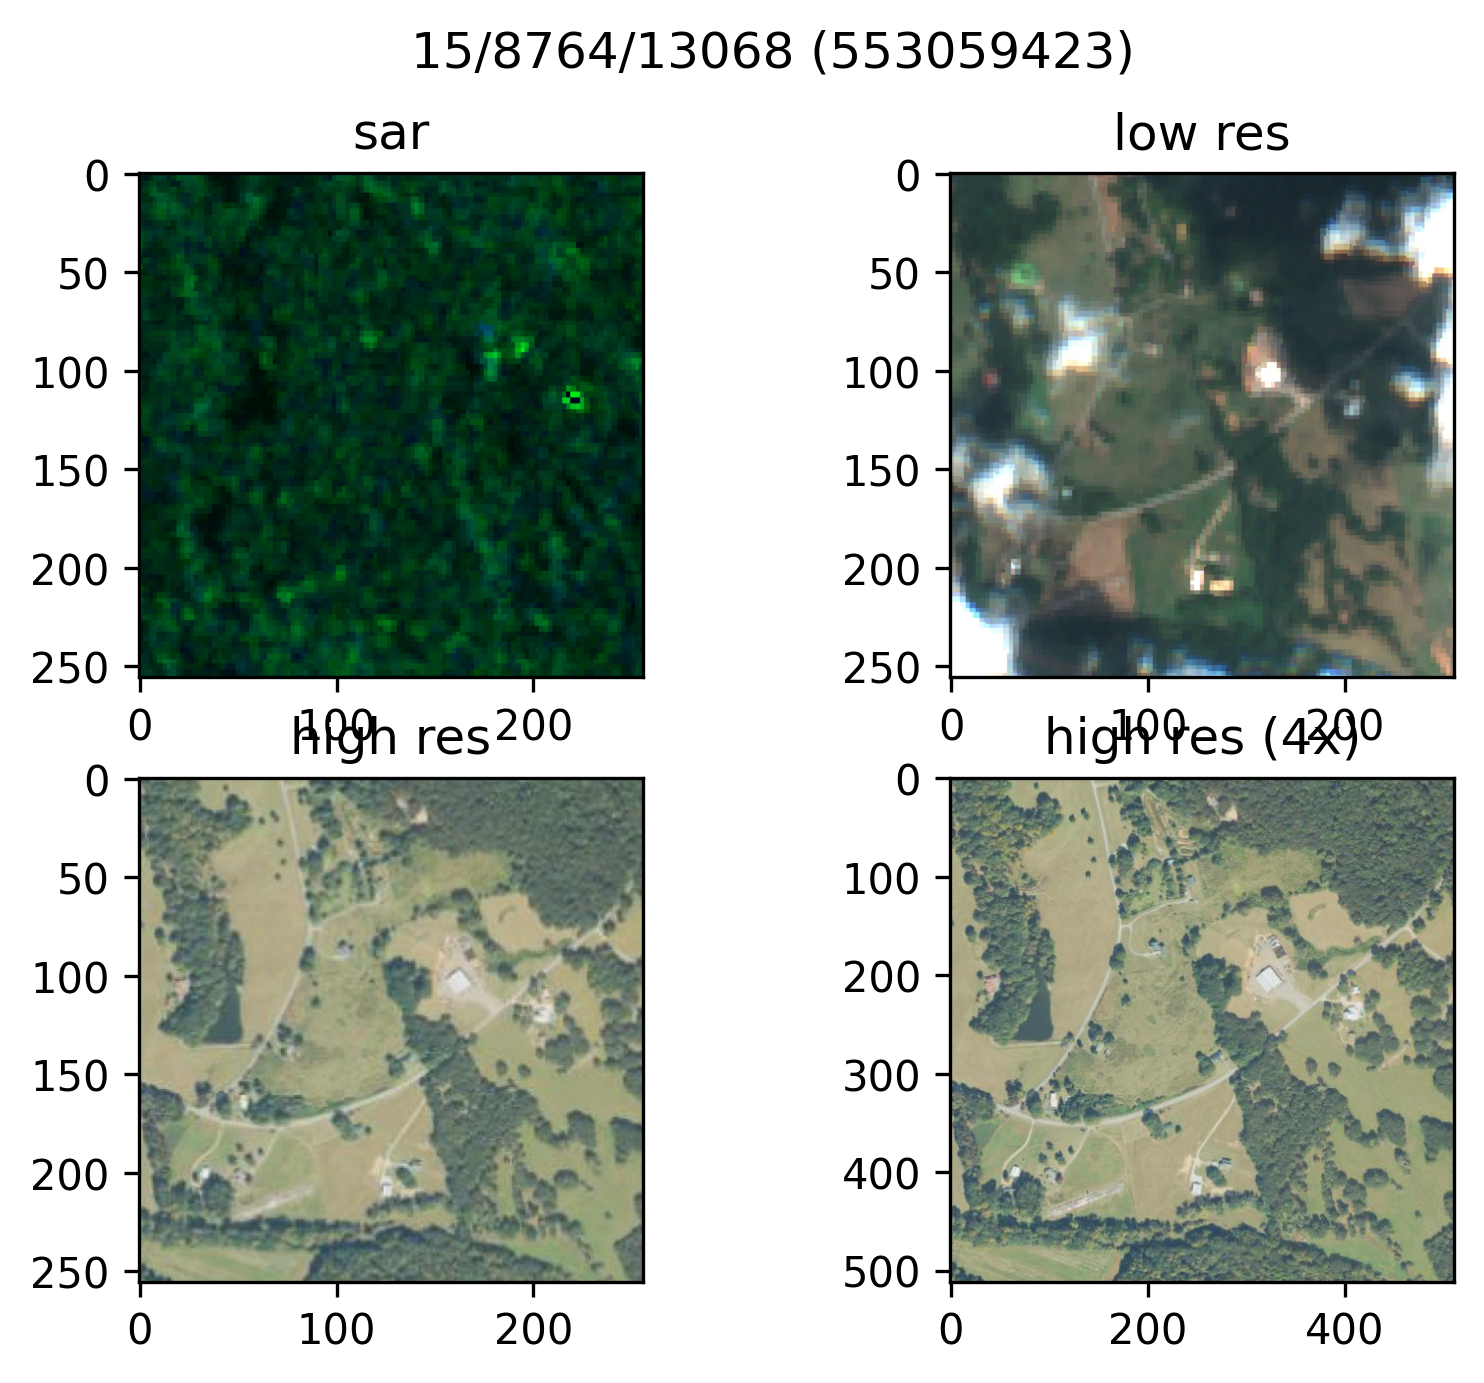

In [40]:
show_sample(random.choice(dataset))